# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,35942,38369,59598,3254,26701,2017
1,17023,5139,5230,7888,330,1755
2,5414,717,2155,2399,69,750


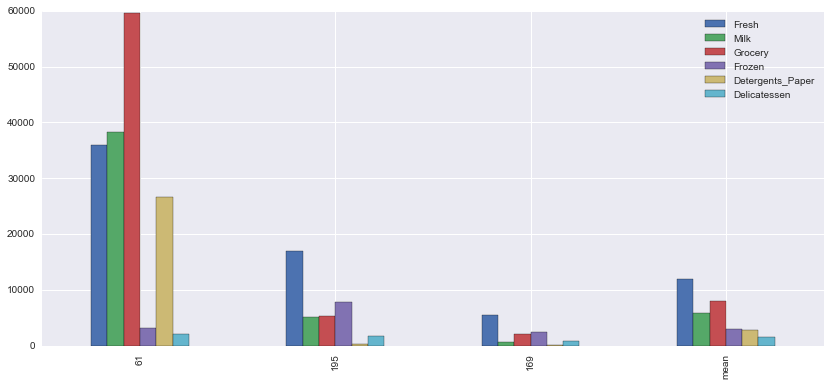

In [123]:
# TODO: Select three indices of your choice you wish to sample from the dataset
import random
indices = [61, 195, 169]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

# Import Seaborn, a very powerful library for Data Visualisation
import seaborn as sns
samples_bar = samples.append(data.describe().loc['mean'])
samples_bar.index = indices + ['mean']
_ = samples_bar.plot(kind='bar', figsize=(14,6))

### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:** The first sample could represent a retailer, supermarket, etc, since they buy large quantities of almost everything (except 'Frozen' and Delicatessen, which are in medium quantity).
The second sample could represent a restaurant that sells lots of dishes that use 'Fresh' and 'Frozen', and uses lots of Grocery, Milk, as well as Delicatessen, at the same time using not that much Detergents_Paper.
The third sample could be a cafe or a small neighborhood grocery shop, as they buy the least amount of all three samples in all categories, and most of it is near the 25% range (except 'Frozen' and 'Delicatessen' which are a bit higher). 

There is also a plot of the three samples and their mean above. There we see that the first sample has much higher values than the average for all parameters, except Frozen and Delicatessen. The second sample point has Fresh ans Frozen a bit higher than their average, Delicatessen more or less around the average, Milk and Grocery a bit lower, and almost no Detergents_Paper compared to the average of the three samples. Compared to their average, the third sample point has also almost no Detergents_Paper, very low Milk, almost average Frozen, and their other values below the three samples average.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [92]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
#print data
new_data = data.drop('Grocery',1)
new_labels = data['Grocery']

#print new_data
#print new_labels
# TODO: Split the data into training and testing sets using the given feature as the target
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data, new_labels, test_size=0.25, random_state=42)

# TODO: Create a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print score

0.681884008544


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:** I tried all of them, kept Grocery in the end. The reported prediction score was 0.682, the highest observed amongst the features. If I understood well, this means that it can be predicted quite well from the remaining features. Thus, it is probably not that necessary, in order to predict the customers' spending habits

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

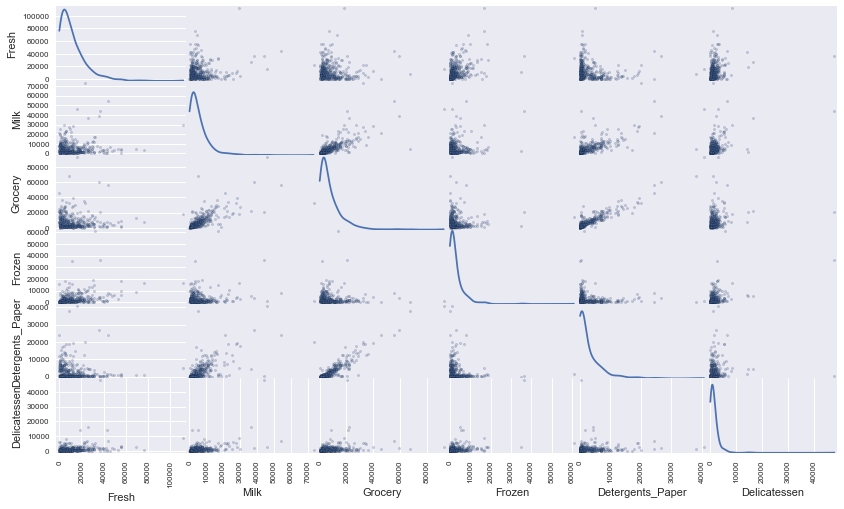

In [93]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:** Grocery seems to have a correlation with Detergents_paper, as well as Milk. To my understanding, this means that they provide similar information. This indicates that my estimation that Grocery is probably not that necessary. As Milk or Detergents_Paper increase, Grocery increases as well. Looking at the third row (Grocery), the graph in the diagonal showing the distribution is positively skewed. This means that the mean is more than the median, the tail of the distribution is a bit longer on the right hand side, and the median is a bit closer to the first quartile than the third quartile. The same is observed for the Detergents_Paper distribution as well as the distribution for Milk (diagonal of the fifth and second rows respectively).

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

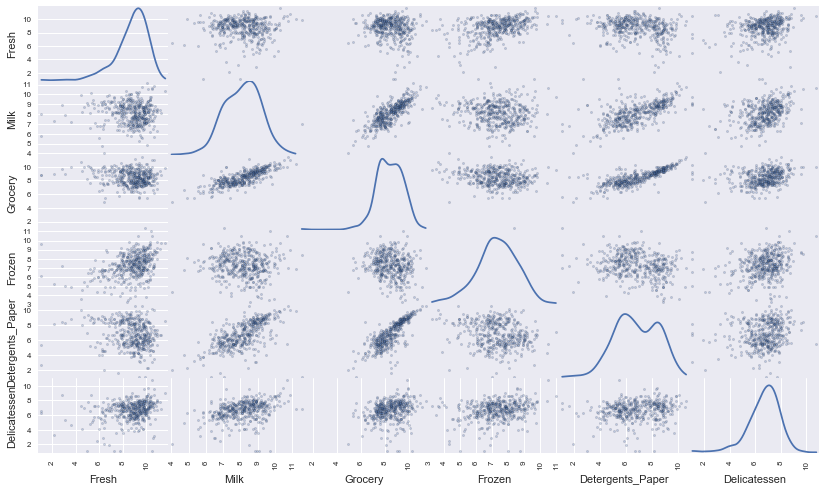

In [94]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [95]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,10.489662,10.555005,10.995377,8.087640,10.192456,7.609367
1,9.742321,8.544614,8.562167,8.973098,5.799093,7.470224
2,8.596743,6.575076,7.675546,7.782807,4.234107,6.620073


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


Data points considered outliers for more than one features:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837


Plot of the distribution of the features with and without the outliers removed:


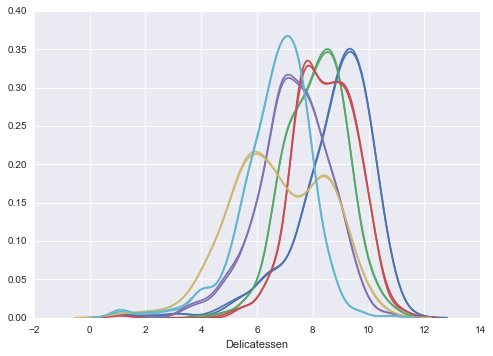

In [99]:
# For each feature find the data points with extreme high or low values
import itertools
import pandas as pd
outliers = []
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    outliers.extend(np.where( np.logical_or((log_data[feature] <= Q1 - step), (log_data[feature] >= Q3 + step))))
    
# OPTIONAL: Select the indices for data points you wish to remove
#get all the duplicates in a list, and create from that a DataFrame
merged = list(itertools.chain.from_iterable(outliers))
merged_df = pd.DataFrame(merged, columns=['d_index'])

#create a column in this DataFrame where it will be stored for each point if it is present in the DataFrame more than once
merged_df['is_duplicated'] = merged_df.duplicated('d_index')

#create a DataFrame with elements only the entries that are outliers for more than one features
out = merged_df.loc[merged_df['is_duplicated'] == True]['d_index']

#create a list to use for droping the outliers from the dataset
outliers  = list(set(out))

# Display the outliers
print "Data points considered outliers for more than one features:"
display(log_data.iloc[outliers])

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

# Plot the distribution of the features with and without the outliers removed
print "Plot of the distribution of the features with and without the outliers removed:"
import seaborn as sns
for col_id in good_data.columns:
    sns.distplot(good_data[col_id], hist=False)#, rug=True)    
for col_id in log_data.columns:
    sns.distplot(log_data[col_id], hist=False)#, rug=True)

### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:** There are several data points considered outliers for each more than one features. In the results above, I provide a table with theese data points (last table before plot). They are the ones with index 65, 66, 75 , 128 and 154. In general it is not always easy to determine if the outliers should be be removed from the dataset, since there is a probability that the values are normal. Just because they are higher or lower than most in more than one features, does not necessarily mean they are abnormal, noisy, erroneous, etc. It depends on our domain knowledge to determine if they can provide us valuable information. And, to be honest, I am not sure what the range of acceptable values is, for the features we are provided with. 

In order to decide whether I should keep or remove the points in question, I performed the analysis wth both datasets: good_data (that does not include the outliers) and log_data (where the 'outliers' are present. The results are available below, as each step is performed twice. Initially for good_data, and then with log_data, in order to compare. 

What I observed was: 
1. Including the outliers, the third PC changed the sign of its weights. The effect of each feature was the exact oposite from when good_data was used.
2. If outliers are included, the sihlouette score is higher for 3 clusters, instead of 2 when the data does not include them, which means the optimal would be to create 3 clusters instead of two.
3. If we plot the clustering results (for 2 clusters) for each of the cases, we notice that the clustering of the points has a non-trivial change. At the same time, it can be observed that the outliers are mostly "isolated" (they are found at a large distance from the closest of the other data points).

Taking the above into consideration, I decided to remove the outliers


## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

First Plot: Fitting PCA in six dimensions with good_data to pca (Outliers removed)
Second Plot: Fitting PCA in six dimensions with log_data to pca (Outliers not removed)


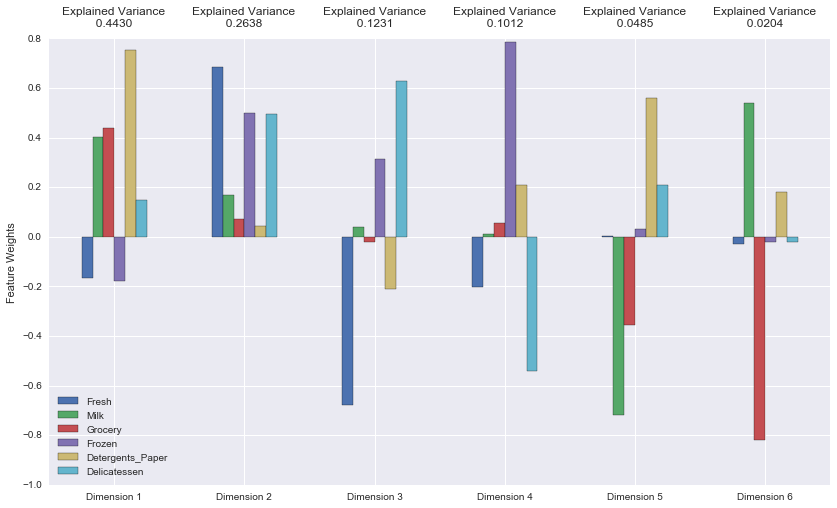

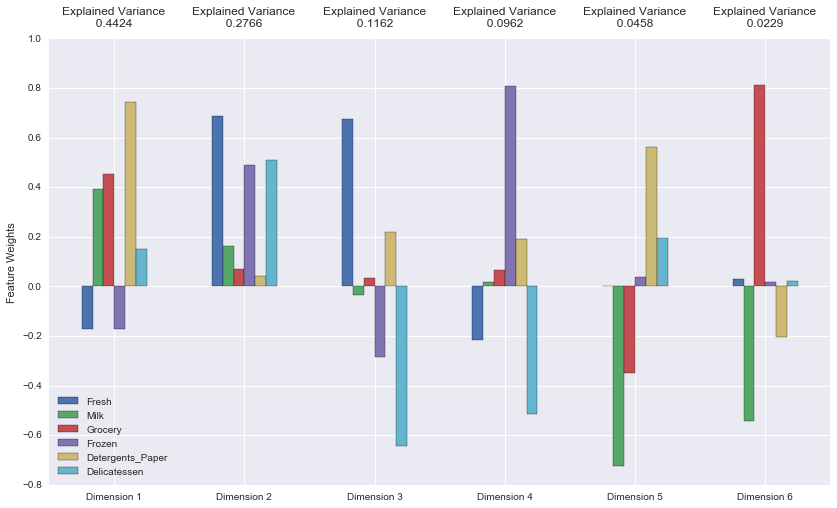

In [100]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
pca = PCA()

pca.fit(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

print "First Plot: Fitting PCA in six dimensions with good_data to pca (Outliers removed)"
# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

pca2 = PCA()

pca2.fit(log_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples2 = pca2.transform(log_samples)

print "Second Plot: Fitting PCA in six dimensions with log_data to pca (Outliers not removed)"
# Generate PCA results plot
pca_results2 = rs.pca_results(log_data, pca2)

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:** The variance explained in total by the first two principal components is 0.7068. The total explained by the four first principal components is 0.9311.
This is observed in the first set of diagrams, which comes from the data after removing the outliers.
The second set of diagrams comes from the data without removing the outliers, and is present only to study the effect of the removal of outliers.
What can be observed in the above visualization with regards to the four first principal components is the following:

1. The first PC is influenced the most by Detergents_Paper. Milk and Grocery also have a noticeable influence on it, and there is a smaller one by Frozen, and Delicatessen, which is cancelled out by Fresh (If Delicatessen and Fresh have the same value, their combined effect on the PC is zero). The smallest influence is that of Fresh and Delicatessen. Individuals with positive PC scores for this PC will have mainly greater values of Detergents_Paper, Milk and Grocery, or Delicatessen. Those with negative scores for this PC will have greater values of Fresh and Frozen. We could then say that the first component has customers that buy a lot of Detergents_Paper, Milk and Grocery.

2. The second PC is influenced the most by Frozen, Delicatessen and Fresh. Milk also has a lower influence, and Milk and Grocery a significantly lower. The Detergents_Paper influence on the second PC is almost insignificant. Individuals with positive PC scores for this PC will have mainly greater values of Frozen, Fresh, Delicatessen, and to a smaller degree Milk and Grocery. We could then say that the second component has customers that buy a lot of Frozen, Fresh and Delicatessen.

3. The third PC is influenced the most by Fresh and Delicatessen. Detergents_Paper and Frozen also have an influence that is significant, however it seems that for equal values they cancel each others' effect on the PC out (they have a more or less equal effect, but on a different direction). Milk also influences the third PC, while the influence of Grocery seems insignificant. Individuals with negative PC scores for this PC will have mainly greater values of Fresh and Detergents_Paper, and even though Grocery also has a negative effect, it is really small. The ones with a positive score will mostly be influenced by Delicatessen, and to a smaller extend Frozen and to an even smaller extend Milk. We could then say that the third component has customers that buy a lot of Delicatessen, Frozen and a smaller amount of Milk.

4. The fourth PC is influenced the most by Frozen and Delicatessen. Detergents_Paper and Fresh also have an influence that is significant. Grocery also influences the fourth PC, while the influence of Milk is the smallest. Individuals with positive PC scores for this PC will have mainly greater values of Frozen and Detergents_Paper, and to a smaller amount Grocery and Milk. The ones with a negative score will mostly be influenced by Delicatessen, and to a smaller extend Fresh. We could then say that the fourth component has customers that buy a lot of Frozen, Detergents_Paper, and a small amount of Grocery.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [101]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,4.3474,2.7451,-1.0220,0.6346,-0.5311,-0.2344
1,-0.8805,1.9121,0.5726,0.4761,-0.6743,-0.1188
2,-2.9590,-0.3480,0.7086,-0.1663,-0.0364,-0.6660


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [102]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)

pca.fit(good_data)
# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

#***********The same is done for log_data (that includes the outliers)*************
#It will be used to study what effect the removal of the outliers had on the results
pca2 = PCA(n_components=2)

pca2.fit(log_data)
# TODO: Transform the good data using the PCA fit above
reduced_data2 = pca2.transform(log_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples2 = pca2.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data2 = pd.DataFrame(reduced_data2, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [103]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,4.3474,2.7451
1,-0.8805,1.9121
2,-2.9590,-0.3480


## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:** The main advantage of K-means is that it is fast. It is faster than the Gaussian Mixture Models, as there are less computations taking place. GMM needs to make more calculations in each iteration, since besides the mean, the maximum likelihood also needs to be calculated. Additionally, since there is no hard assignment of data points to a cluster, a much larger number of them needs to be included in the calculations performed for each cluster. GMM has the advantage that it is more flexible, and can identify hidden, non observable parameters in the data. Since in the data provided there was no clear structure identified, and the size of the data set is small (thus GMM will not be problematic) I will use GMM.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [106]:
# TODO: Apply your clustering algorithm of choice to the reduced data 
from sklearn.mixture import GMM
from sklearn.metrics import silhouette_score

for n_components in range (2, 20):
    #print n_components
    clusterer = GMM(n_components)

    clusterer.fit(reduced_data)

# TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
    
    centers = clusterer.means_
    #print centers
# TODO: Predict the cluster for each transformed sample data 
    if n_components < 4:
        sample_preds = clusterer.fit_predict(pca_samples)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    
    print "The silhouette score for ", n_components, "clusters is : ", score
    
#after running the algorithms for n_components 2:20, it is run once again with n_components= 2,
#so that the variables have the right values in order to be used in the next question
clusterer = GMM(n_components=2)

clusterer.fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
    
centers = clusterer.means_

# TODO: Predict the cluster for each transformed sample data 

sample_preds = clusterer.predict(pca_samples)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)


print ""
print "...................."
print "Same analysis is now performed in the original data (log_data - including outliers previously identified)"
print "This is done in order to study the effect the removal of outliers had"
print "...................."
print ""

#********Same analysis is now performed in the original data (log_data - including outliers previously identified)**********
for n_components in range (2, 20):
    #print n_components
    clusterer2 = GMM(n_components)

    clusterer2.fit(reduced_data2)

# TODO: Predict the cluster for each data point
    preds2 = clusterer2.predict(reduced_data2)

# TODO: Find the cluster centers
    
    centers2 = clusterer2.means_
    #print centers
# TODO: Predict the cluster for each transformed sample data 
    if n_components < 4:
        sample_preds2 = clusterer2.fit_predict(pca_samples2)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score2 = silhouette_score(reduced_data2, preds2)
    
    print "The silhouette score2  - of log_data (including outliers) - for ", n_components, "clusters is : ", score2

    

#after running the algorithms for n_components 2:20, it is run once again with n_components= 2,
#so that the variables have the right values in order to be used in the next question

clusterer2 = GMM(n_components=2)

clusterer2.fit(reduced_data2)

# TODO: Predict the cluster for each data point
preds2 = clusterer2.predict(reduced_data2)

# TODO: Find the cluster centers
    
centers2 = clusterer2.means_

# TODO: Predict the cluster for each transformed sample data 

sample_preds2 = clusterer2.predict(pca_samples2)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score2 = silhouette_score(reduced_data2, preds2)



The silhouette score for  2 clusters is :  0.411818864386
The silhouette score for  3 clusters is :  0.372313708076
The silhouette score for  4 clusters is :  0.337969395886
The silhouette score for  5 clusters is :  0.280512960228
The silhouette score for  6 clusters is :  0.272714235376
The silhouette score for  7 clusters is :  0.325428654711
The silhouette score for  8 clusters is :  0.313115021391
The silhouette score for  9 clusters is :  0.306093014477
The silhouette score for  10 clusters is :  0.271973573901
The silhouette score for  11 clusters is :  0.27909994065
The silhouette score for  12 clusters is :  0.289154293422
The silhouette score for  13 clusters is :  0.226050795326
The silhouette score for  14 clusters is :  0.26267220239
The silhouette score for  15 clusters is :  0.217484407895
The silhouette score for  16 clusters is :  0.196746155701
The silhouette score for  17 clusters is :  0.232868696325
The silhouette score for  18 clusters is :  0.185760383108
The sil

### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:** The silhouette scores computed for several cluster numbers are:

The silhouette score for  2 clusters is :  0.411818864386

The silhouette score for  3 clusters is :  0.372313708076

The silhouette score for  4 clusters is :  0.337969395886

The silhouette score for  5 clusters is :  0.280512960228

The silhouette score for  6 clusters is :  0.272714235376

The silhouette score for  7 clusters is :  0.325428654711

The silhouette score for  8 clusters is :  0.313115021391

The silhouette score for  9 clusters is :  0.306093014477

The silhouette score for  10 clusters is :  0.271973573901

The silhouette score for  11 clusters is :  0.27909994065

The silhouette score for  12 clusters is :  0.289154293422

The silhouette score for  13 clusters is :  0.226050795326

The silhouette score for  14 clusters is :  0.26267220239

The silhouette score for  15 clusters is :  0.217484407895

The silhouette score for  16 clusters is :  0.196746155701

The silhouette score for  17 clusters is :  0.232868696325

The silhouette score for  18 clusters is :  0.185760383108

The silhouette score for  19 clusters is :  0.184058793853

Of these, the best was that for 2 clusters (~0.41)

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 


....................
First plot displays the results for the data with the outliers removed (good_data)

Second plot displays the results for the data with the outliers included (log_data)
....................

This is done in order to study the effect the removal of outliers had
....................



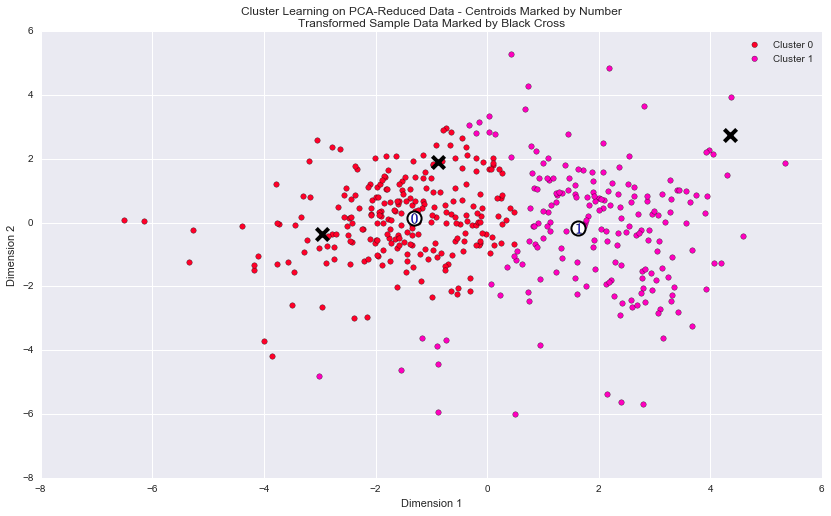

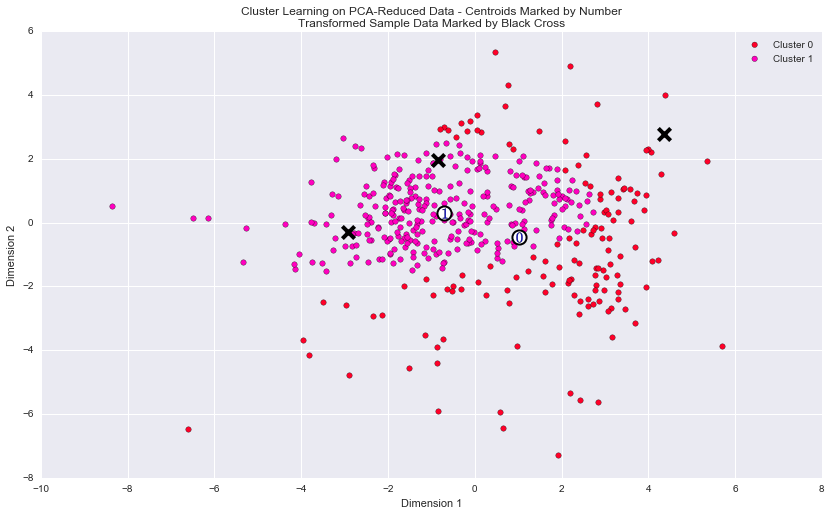

In [110]:

print ""
print "...................."
print "First plot displays the results for the data with the outliers removed (good_data)"
print ""
print "Second plot displays the results for the data with the outliers included (log_data)"
print "...................."
print ""
print "This is done in order to study the effect the removal of outliers had"
print "...................."
print ""

# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

# Display the results of the clustering from implementation when the outliers are included, for comparison
rs.cluster_results(reduced_data2, preds2, centers2, pca_samples2)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8812.0,2052.0,2689.0,2058.0,337.0,712.0
Segment 1,4316.0,6347.0,9555.0,1036.0,3046.0,945.0


   Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  35942  38369    59598    3254             26701          2017
1  17023   5139     5230    7888               330          1755
2   5414    717     2155    2399                69           750


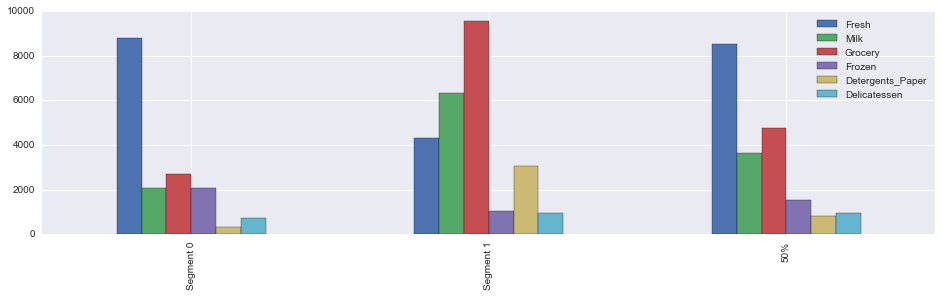

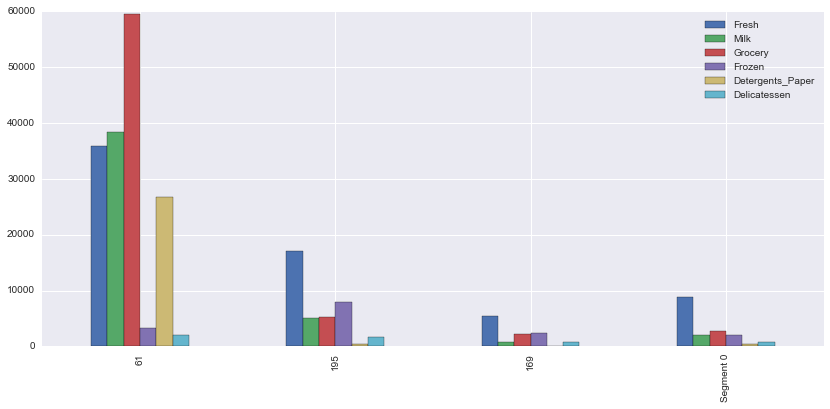

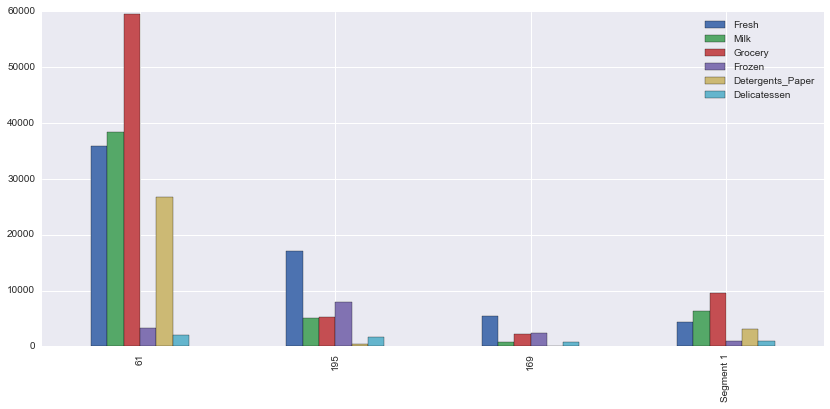

In [136]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)
# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)
# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

#Plot the two cluster centers and the data median values in one plot, so we can see the characteristics of the cluster centers more easily
true_centers1 = true_centers.append(data.describe().ix['50%'])
true_centers1.plot(kind = 'bar', figsize = (16, 4))

# Import Seaborn, a very powerful library for Data Visualisation
import seaborn as sns
print samples

samples_bar = samples.append(true_centers.loc['Segment 0'])
samples_bar.index = indices + ['Segment 0']
_ = samples_bar.plot(kind='bar', figsize=(14,6))

samples_bar = samples.append(true_centers.loc['Segment 1'])
samples_bar.index = indices + ['Segment 1']
_ = samples_bar.plot(kind='bar', figsize=(14,6))

### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:** If we see the first bar plot above, where the two cluster centers are compared to the mean of the data, we can see that the first data point above represents customers who spend more than the average on Grocery, Milk, and Detergents_Paper. They spend more or less the average on Delicatessen, and slightly less than average on Frozen and Fresh. That seems similar to the first point in Question 1: it could be a retailer, supermarket, etc.

On the other hand, the second cluster center represents customers that spend more than the average on Fresh and Frozen, and less than average on the other categories. This is more similar to the second and third points selected in Question 1: it could represent a restaurant that sells lots of dishes that use 'Fresh' and 'Frozen', and uses less Gocery, Milk, as well as Delicatessen, at the same time using not that much Detergents_Paper.

Additionally, we can examine the second and third plot above, where the three sample points are compared to the two cluster centers (the points in true_centers). As we can see, the first sample looks similar to the center of Segment 1: Grocery has the highest value, then Milk, then Fresh, etc. The second and third sample look more like the cluster center of Segment 0: Fresh has the highest value, Detergents_Paper has a very low value, Milk, Grocery and Frozen have a value much lower than Fresh, and Delicatessen a low value (however not as low as Detergents_Paper) 
From the above observations, I would expect the first sample point to be in Cluster 1, and the other 2 in Cluster 0

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [138]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred
    
for i,j in enumerate(pca_samples):
    print "Probability of Sample {}: {}".format(i,clusterer.predict_proba([j])[0])

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 0
Probability of Sample 0: [ 0.00226489  0.99773511]
Probability of Sample 1: [ 0.81712845  0.18287155]
Probability of Sample 2: [ 0.98428716  0.01571284]


**Answer:** As seen above, the first sample point (point 0) is predicted to be in Cluster 0, whereas the second and third sample points (points 1, 2) are predicted to be in Cluster 1. The third sample seems to belong to Cluster 1 with higher probability (~0.998), however the second one has also a very high probability of belonging to the same Cluster (~0.877). On the other hand, the probability of Sample 0 belonging to Cluster 0 is far greater than the one for Cluster 1. This is also in agreement with the initial intuition, that sample points 1 and 2 are more similar to each other than to sample point 0. Additionally, this is consistent with our expectations mentioned above, after comparing each of the sample points to both cluster centers

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. *How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*  
**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:** The distributor can select a random sample of a certain size (usually around 50%) out of each cluster. 
Each of the samples of the same cluster should have a similar behaviour. 
For each cluster, 50% of the customers will belong to the Test/Experimental Group, and 50% to the Control Group. 
Then, the distributor will select the metric that defines if the testing of the new delivery service is successfull or not. 
This can be the money spent by the customers. 

After that, the delivery service will be changed for the customers included in the Experimental Group, and remain the same for the Control Group (for both clusters). 
It will remain like this for a predefined time, long enough to be able to measure reactions. 

At the end, the distributor will compare the results of the Experimental Group regarding the metric set, and compare them with the goals set. 
If the goals for the Experimental Group for either of the clusters have been met, then the distributor needs to compare the results of the Experimental Group, with those of the Control Group of therespective cluster. 
If not, the delivery for all the members of the cluster should revert to the delivery service of 5 times a week. 

For each cluster there two possibilities: The performance of the Experimental Group is similar to that of the Control Group, or otherwise. 
If these results are similar, it means that any change in the results was not caused by the change in the delivery service, but other causes. 
Then we can revert to the old delivery service for all groups of the cluster. 
If on the other hand the results of the Experimental group of a cluster are significantly different (better) from those of the Control Group, and the targets have been met, then the distributor can roll out the new delivery service to all members of the specific cluster. 
Of course, if the results of the Experimental Group are worse than those of the Control Group for a cluster, then all the members of this cluster will be offered the old delivery service.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:** The distributor now has labeled data, since a customer segment is assigned to each of the customers present in the dataset. Thus, any supervised lerner classification model can now be used in order to assign new customers to a segment, as long as they provide their estimated product spending data. The target variable would be the customer segment, receiving values of 0 and 1 (representing the 1 clusters/customer segments identified previously).

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

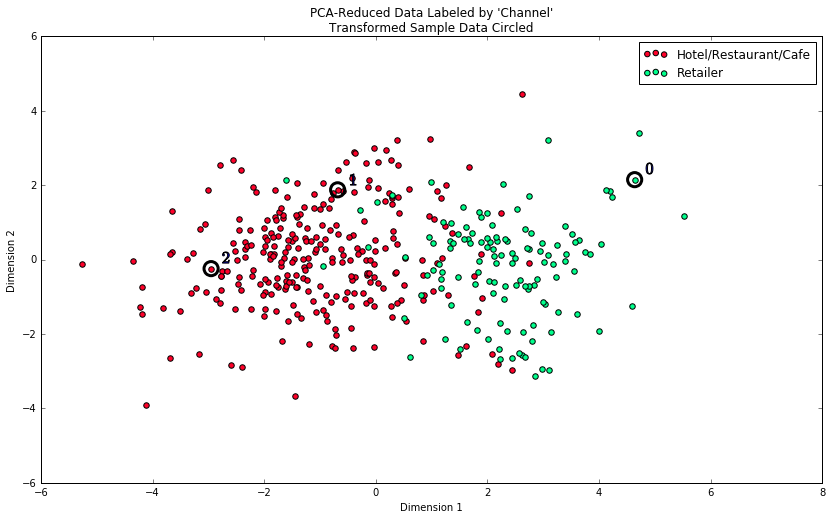

In [28]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:** In general, the number of clusters as well as the clustering algorithm chosen perform relatively well. The form of the clusters is mor or less the same in both cases, with the split at a similar position. Of course, there are points that existed in one of the two previous clusters, that are now labeled differently. In the new distribution there are no customer segments that can be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes'. However, to a great extend, I consider the new classification consistent with the previous definition of customer segments. Finally, the sample points also belong to the same customer segments as before. This does not say much about the old classification in general however since they are displayed, it does not hurt to mention their current classification compared to how they were classified with the previous customer segment definition.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.